### OBS: I need to use numpy==1.19.5 to tensorflow work in my machine

In [30]:
from matplotlib import pyplot as P
import pandas as pd
import numpy as np
from sklearn.preprocessing import normalize
import tensorflow.keras as  keras
from tensorflow.keras.layers import Dense, Activation, Dropout, Bidirectional
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow.keras import backend as K
from time import time
from sklearn.metrics import *

In [31]:
def split_data(df, look_back=12, ratio=0.8, predict_n=5, Y_column=0):
    """
    Split the data into training and test sets
    Keras expects the input tensor to have a shape of (nb_samples, timesteps, features).
    :param df: Pandas dataframe with the data.
    :param look_back: Number of weeks to look back before predicting
    :param ratio: fraction of total samples to use for training
    :param predict_n: number of weeks to predict
    :param Y_column: Column to predict
    :return:
    """
    df = np.nan_to_num(df.values).astype("float64")
    # n_ts is the number of training samples also number of training sets
    # since windows have an overlap of n-1
    n_ts = df.shape[0] - look_back - predict_n + 1
    # data = np.empty((n_ts, look_back + predict_n, df.shape[1]))
    data = np.empty((n_ts, look_back + predict_n, df.shape[1]))
    for i in range(n_ts):  # - predict_):
        #         print(i, df[i: look_back+i+predict_n,0])
        data[i, :, :] = df[i: look_back + i + predict_n, :]
    # train_size = int(n_ts * ratio)
    train_size = int(df.shape[0] * ratio) - look_back
    print(train_size)

    # We are predicting only column 0
    X_train = data[:train_size, :look_back, :]
    Y_train = data[:train_size, look_back:, Y_column]
    X_test = data[train_size:, :look_back, :]
    Y_test = data[train_size:, look_back:, Y_column]

    return X_train, Y_train, X_test, Y_test


def normalize_data(df, log_transform=False):
    """
    Normalize features in the example table
    :param df:
    :return:
    """

    if 'municipio_geocodigo' in df.columns:
        df.pop('municipio_geocodigo')

    for col in df.columns:
        if col.startswith('nivel'):
            # print(col)
            le = LabelEncoder()
            le.fit(df[col])
            df[col] = le.transform(df[col])
    df.fillna(0, inplace=True)
    norm = normalize(df, norm='max', axis=0)
    if log_transform==True:
        norm = np.log(norm)
    df_norm = pd.DataFrame(norm, columns=df.columns)

    return df_norm, df.max(axis=0)

In [3]:
def build_model(hidden, features, predict_n, look_back=10, batch_size=1):
    """
    Builds and returns the LSTM model with the parameters given
    :param hidden: number of hidden nodes
    :param features: number of variables in the example table
    :param look_back: Number of time-steps to look back before predicting
    :param batch_size: batch size for batch training
    :return:
    """
    inp = keras.Input(
        shape=(look_back, features),
        # batch_shape=(batch_size, look_back, features)
    )
    x = LSTM(
        hidden,
        input_shape=(look_back, features),
        stateful=False,
        batch_input_shape=(batch_size, look_back, features),
        return_sequences=True,
        # activation='relu',
        dropout=0.1,
        recurrent_dropout=0.1,
        implementation=2,
        unit_forget_bias=True,
    )(inp, training=True)
    x = Dropout(0.2)(x, training=True)
    x = LSTM(
        hidden,
        input_shape=(look_back, features),
        stateful=False,
        batch_input_shape=(batch_size, look_back, features),
        return_sequences=True,
        # activation='relu',
        dropout=0.1,
        recurrent_dropout=0.1,
        implementation=2,
        unit_forget_bias=True,
    )(x, training=True)
    x = Dropout(0.2)(x, training=True)
    x = LSTM(
        hidden,
        input_shape=(look_back, features),
        stateful=False,
        batch_input_shape=(batch_size, look_back, features),
        return_sequences=True,
        # activation='relu',
        dropout=0.1,
        recurrent_dropout=0.1,
        implementation=2,
        unit_forget_bias=True,
    )(x, training=True)
    x = Dropout(0.2)(x, training=True)
    x = LSTM(
        hidden,
        input_shape=(look_back, features),
        stateful=False,
        return_sequences=False,
        batch_input_shape=(batch_size, look_back, features),
        # activation='relu',
        dropout=0.1,
        recurrent_dropout=0.1,
        implementation=2,
        unit_forget_bias=True,
    )(x, training=True)
    x = Dropout(0.2)(x, training=True)
    out = Dense(
        predict_n,
        activation="relu",
        kernel_initializer="random_uniform",
        bias_initializer="zeros",
    )(x)
    model = keras.Model(inp, out)

    start = time()
    model.compile(loss="msle", optimizer="adam", metrics=["accuracy", "mape", "mse"])
    print("Compilation Time : ", time() - start)
    plot_model(model, to_file="LSTM_model.png")
    print(model.summary())
    return model

def transf_model(hidden, features, predict_n, look_back=10, batch_size=1, filename = 'trained_2312908_model_dengue.h5' ):
    """
    Builds and returns the LSTM model with the parameters given
    :param hidden: number of hidden nodes
    :param features: number of variables in the example table
    :param look_back: Number of time-steps to look back before predicting
    :param batch_size: batch size for batch training
    :return:
    """
    # get the model trained with the dengue data 
    base_model = keras.models.load_model(filename)
    setattr(base_model.get_layer('lstm_7'), 'return_sequences', True)
    
    inp = keras.Input(
        shape=(look_back, features),
        # batch_shape=(batch_size, look_back, features)
    )


    x = base_model.get_layer('lstm_4')(inp, training=False)
    x = base_model.get_layer('dropout_4')(x, training=False)
    x = base_model.get_layer('lstm_5')(x, training=False)
    x = base_model.get_layer('dropout_5')(x, training=False)
    x = base_model.get_layer('lstm_6')(x, training=False)
    x = base_model.get_layer('dropout_6')(x, training=False)
    x = base_model.get_layer('lstm_7')(x,training=False)
    x = base_model.get_layer('dropout_7')(x, training=False)
    #x = base_model.get_layer('dense_1')(x, training=False)

    # new layer 

    x = Bidirectional(LSTM(
        hidden,
        input_shape=(look_back, features),
        stateful=False,
        batch_input_shape=(batch_size, look_back, features),
        # activation='relu',
        dropout=0.1,
        recurrent_dropout=0.1,
        implementation=2,
        unit_forget_bias=True,
    ), merge_mode = 'ave')(x, training=True)
    x = Dropout(0.2)(x, training=True)
    out = Dense(
        predict_n,
        activation="relu",
        kernel_initializer="random_uniform",
        bias_initializer="zeros",
    )(x, training=True)
    
    model = keras.Model(inp, out)
    
    start = time()
    #opt = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(loss="msle", optimizer= 'Adam', metrics=["accuracy", "mape", "mse"])
    print("Compilation Time : ", time() - start)
    #plot_model(model, to_file="LSTM_model.png")
    #print(model.summary())
    return model 

def train(doenca, model, X_train, Y_train, batch_size=1, epochs=10, geocode=None, overwrite=True):
    TB_callback = TensorBoard(
        log_dir="./tensorboard",
        histogram_freq=0,
        write_graph=True,
        write_images=True,
        # embeddings_freq=10
    )

    hist = model.fit(
        X_train,
        Y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_split=0.15,
        verbose=0,
        callbacks=[TB_callback, EarlyStopping(patience=15)]
    )
    
    model.save(f"trained_{geocode}_model_{doenca}.h5", overwrite=overwrite)
    return hist

def evaluate(model, Xdata, Ydata, uncertainty=True):
    if uncertainty:
        predicted = np.stack([model.predict(Xdata, batch_size=1, verbose=0) for i in range(100)], axis=2)
    else:
        predicted = model.predict(Xdata, batch_size=1, verbose=0)
    return predicted

In [4]:
def plot_predicted_vs_data(predicted, Ydata, indice, label, pred_window, factor, split_point=None, uncertainty=False):
    """
    Plot the model's predictions against data
    :param predicted: model predictions
    :param Ydata: observed data
    :param indice:
    :param label: Name of the locality of the predictions
    :param pred_window:
    :param factor: Normalizing factor for the target variable
    """

    P.clf()
    if len(predicted.shape) == 2:
        df_predicted = pd.DataFrame(predicted).T
        df_predicted25 = None
    else:
        df_predicted = pd.DataFrame(np.percentile(predicted, 50, axis=2))
        df_predicted25 = pd.DataFrame(np.percentile(predicted, 2.5, axis=2))
        df_predicted975 = pd.DataFrame(np.percentile(predicted, 97.5, axis=2))
        uncertainty = True
    ymax = max(predicted.max() * factor, Ydata.max() * factor)
    P.vlines(indice[split_point], 0, ymax, "g", "dashdot", lw=2)
    P.text(indice[split_point + 2], 0.6 * ymax, "Out of sample Predictions")
    # plot only the last (furthest) prediction point
    P.plot(indice[len(indice)-Ydata.shape[0]:], Ydata[:, -1] * factor, 'k-', alpha=0.7, label='data')
    P.plot(indice[len(indice)-Ydata.shape[0]:], df_predicted.iloc[:,-1] * factor, 'r-', alpha=0.5, label='median')
    if uncertainty:
        P.fill_between(indice[7:], df_predicted25[df_predicted25.columns[-1]] * factor,
                       df_predicted975[df_predicted975.columns[-1]] * factor,
                       color='b', alpha=0.3)

    # plot all predicted points
    # P.plot(indice[pred_window:], pd.DataFrame(Ydata)[7] * factor, 'k-')
    # for n in range(df_predicted.shape[1] - pred_window):
    #     P.plot(
    #         indice[n: n + pred_window],
    #         pd.DataFrame(Ydata.T)[n] * factor,
    #         "k-",
    #         alpha=0.7,
    #     )
    #     P.plot(indice[n: n + pred_window], df_predicted[n] * factor, "r-")
    #     try:
    #         P.vlines(
    #             indice[n + pred_window],
    #             0,
    #             df_predicted[n].values[-1] * factor,
    #             "b",
    #             alpha=0.2,
    #         )
    #     except IndexError as e:
    #         print(indice.shape, n, df_predicted.shape)
    tag = '_unc' if uncertainty else ''
    P.grid()
    P.title("Predictions for {}".format(label))
    P.xlabel("time")
    P.ylabel("incidence")
    P.xticks(rotation=70)
    P.legend(["data", "predicted"])
    P.show()

In [5]:
def plot_transf_predicted_vs_data(predicted_t, predicted, Ydata, indice, label, pred_window, factor, split_point=None, uncertainty=False):
    """
    Plot the model's predictions against data
    :param predicted: model predictions
    :param Ydata: observed data
    :param indice:
    :param label: Name of the locality of the predictions
    :param pred_window:
    :param factor: Normalizing factor for the target variable
    """

    P.clf()
    df_predicted_t = pd.DataFrame(np.percentile(predicted_t, 50, axis = 2))
    df_predicted = pd.DataFrame(np.percentile(predicted, 50, axis=2))
        
    uncertainty = True
    #ymax = max(predicted.max() * factor, Ydata.max() * factor)
    #P.vlines(indice[split_point], 0, ymax, "g", "dashdot", lw=2)
    #P.text(indice[split_point + 2], 0.6 * ymax, "Out of sample Predictions")
    # plot only the last (furthest) prediction point
    P.plot(indice[len(indice)-Ydata.shape[0]:], Ydata[:, -1] * factor, 'k-', alpha=0.7, label='data')
    P.plot(indice[len(indice)-Ydata.shape[0]:], df_predicted.iloc[:,-1] * factor, 'r-', alpha=0.5, label='chik model')
    P.plot(indice[len(indice)-Ydata.shape[0]:], df_predicted_t.iloc[:,-1] * factor, 'g-', alpha=0.5, label='transf. model')
   
                                  
    tag = '_unc' if uncertainty else ''
    P.grid()
    P.title("Predictions for {}".format(label))
    P.xlabel("time")
    P.ylabel("incidence")
    P.xticks(rotation=70)
    P.legend()
    P.show()

### Getting the data of dengue to train the model 

In [6]:
def get_dengue_data(city, end_date = '2016-12-31', file = 'data_dengue.csv'): 
    data_dengue = pd.read_csv(file)
    data_dengue.set_index('Unnamed: 0', inplace = True)
    data_dengue.index.name = 'data'
    data_dengue.index = pd.to_datetime(data_dengue.index) 

    target_col = list(data_dengue.columns).index("casos_est_{}".format(city))

    # definindo o período de treino apenas
    data_dengue = data_dengue.loc[:end_date]

    norm_data_dengue, max_features = normalize_data(data_dengue)
    factor_dengue = max_features[target_col]

    ##split test and train
    X_train, Y_train, X_test, Y_test = split_data(
            norm_data_dengue,
            look_back=4,
            ratio=1,
            predict_n=4,
            Y_column=target_col,
    )
    
    return data_dengue,factor_dengue,  X_train, Y_train

### Getting the data of chickunguya 

In [7]:
def get_chik_data(city, ini_date = '2016-01-01', end_date= '2017-12-31', filename = 'data_chik.csv'):
    data_chik = pd.read_csv(filename)
    data_chik.set_index('Unnamed: 0', inplace = True)
    data_chik.index.name = 'data'
    data_chik.index = pd.to_datetime(data_chik.index) 
    
    target_col = list(data_chik.columns).index("casos_est_{}".format(city))

    data_chik = data_chik.loc[ini_date:end_date] 

    norm_data_chik, max_features = normalize_data(data_chik)
    factor_chik = max_features[target_col]

    X_train_chik, Y_train_chik, X_test_chik, Y_test_chik = split_data(
            norm_data_chik,
            look_back=4,
            ratio=0.5,
            predict_n=4,
            Y_column=target_col,
    )
    
    return data_chik, factor_chik, X_train_chik, Y_train_chik, X_test_chik, Y_test_chik

In [8]:
city = 2312908 # Sobral
state = 'CE'

### Applying the model 

#### Getting the data

In [9]:
data_chik,factor_chik,  X_train_chik, Y_train_chik, X_pred, Y_pred = get_chik_data(city, ini_date = '2016-01-01', end_date= '2017-12-31', filename = f'data_chik_{city}_{state}.csv')


data_chik.index[len(X_train_chik)].strftime('%Y-%m-%d')

48


'2016-12-04'

In [10]:
data_dengue, factor_degue, X_train, Y_train = get_dengue_data(city, end_date = data_chik.index[len(X_train_chik)].strftime('%Y-%m-%d'), file = f'data_dengue_{city}_{state}.csv')


358


#### Training the dengue model 

#### Loading the dengue model 

In the dengue model I need to use hidden = 12 to improve the performance. 

In [12]:
%%time
model_dengue =  keras.models.load_model(f'trained_{city}_model_dengue.h5')

CPU times: user 328 ms, sys: 10.6 ms, total: 339 ms
Wall time: 337 ms


In [13]:
model_dengue.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 4, 30)]           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 4, 12)             2064      
_________________________________________________________________
dropout_4 (Dropout)          (None, 4, 12)             0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 4, 12)             1200      
_________________________________________________________________
dropout_5 (Dropout)          (None, 4, 12)             0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 4, 12)             1200      
_________________________________________________________________
dropout_6 (Dropout)          (None, 4, 12)             0   

In [14]:
predicted_dengue = np.stack([model_dengue.predict(X_train, batch_size=1, verbose=0) for i in range(100)], axis=2)

2022-02-13 11:37:00.816851: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


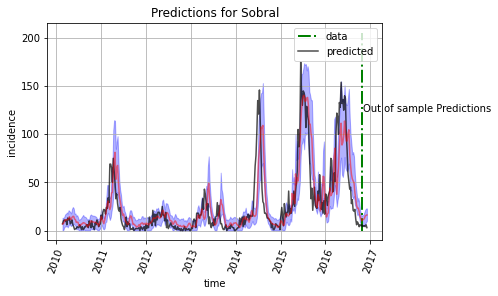

In [15]:
indice = list(data_dengue.index)
indice = [i.date() for i in indice]

plot_predicted_vs_data(predicted_dengue, Y_train, indice, 'Sobral', 4, factor_degue, split_point=len(Y_train), uncertainty= True)   

#### Transfer learning 

##### Just apply the dengue model (it's not transfer learning)

In [16]:
predicted_in_1 = evaluate(model_dengue, X_train_chik, Y_train_chik)
predicted_out_1 = evaluate(model_dengue, X_pred, Y_pred)

predicted_chik_1 = np.concatenate((predicted_in_1, predicted_out_1), axis=0)

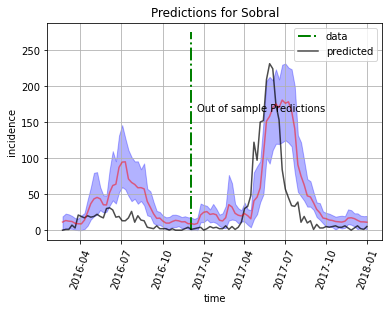

In [17]:
indice = list(data_chik.index)
indice = [i.date() for i in indice]

plot_predicted_vs_data(predicted_chik_1, np.concatenate((Y_train_chik, Y_pred), axis=0), indice, 'Sobral', 4, factor_chik, split_point=len(Y_train_chik), uncertainty= True)

##### Update the dengue model with the chik data

In [18]:
%%time
train('chik_upd', model_dengue, X_train_chik, Y_train_chik, batch_size=1, epochs=100, geocode= city, overwrite=True)

2022-02-13 11:38:07.620174: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2022-02-13 11:38:07.620186: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2022-02-13 11:38:07.620579: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2022-02-13 11:38:09.385695: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2022-02-13 11:38:09.385711: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2022-02-13 11:38:09.391440: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2022-02-13 11:38:09.416088: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2022-02-13 11:38:09.438971: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: ./tensorboard/train/plugins/profile/2022_02_13_11_38_09
2022-02-13 11:38:09.445600: I tensorflow/core/

CPU times: user 10.6 s, sys: 826 ms, total: 11.5 s
Wall time: 9.2 s


In [19]:
model_upd = keras.models.load_model(f'trained_{city}_model_chik_upd.h5')

In [20]:
predicted_in_2 = evaluate(model_upd, X_train_chik, Y_train_chik)
predicted_out_2 = evaluate(model_upd, X_pred, Y_pred)

predicted_chik_2 = np.concatenate((predicted_in_2, predicted_out_2), axis=0)

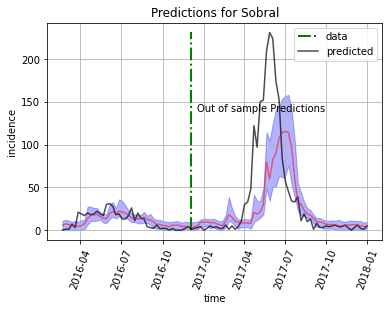

In [21]:
indice = list(data_chik.index)
indice = [i.date() for i in indice]

plot_predicted_vs_data(predicted_chik_2, np.concatenate((Y_train_chik, Y_pred), axis=0), indice, 'Sobral', 4, factor_chik, split_point=len(Y_train_chik), uncertainty= True)

#### Transfer_learning model 

I add a new bi-lstm layer to the chik data and freeze the other layers of the original dengue model

In [22]:
%%time
transf_model =  transf_model(4, X_train_chik.shape[2],4, 4, filename = f'trained_{city}_model_dengue.h5' )
 
train('chik_transf', transf_model, X_train_chik, Y_train_chik, batch_size=1, epochs=100, geocode= city, overwrite=True)

Compilation Time :  0.0029642581939697266


2022-02-13 11:38:34.523760: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2022-02-13 11:38:34.523778: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2022-02-13 11:38:34.523795: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2022-02-13 11:38:37.934659: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2022-02-13 11:38:37.934681: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2022-02-13 11:38:38.085237: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2022-02-13 11:38:38.105572: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2022-02-13 11:38:38.121236: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: ./tensorboard/train/plugins/profile/2022_02_13_11_38_38
2022-02-13 11:38:38.129910: I tensorflow/core/

CPU times: user 13.7 s, sys: 838 ms, total: 14.6 s
Wall time: 11.7 s


In [25]:
%%time
model_transf =  keras.models.load_model(f'trained_{city}_model_chik_transf.h5')

predicted_in_3 = evaluate(model_transf, X_train_chik, Y_train_chik)
predicted_out_3 = evaluate(model_transf, X_pred, Y_pred)

predicted_chik_3 = np.concatenate((predicted_in_3, predicted_out_3), axis=0)

CPU times: user 19.7 s, sys: 552 ms, total: 20.3 s
Wall time: 18.4 s


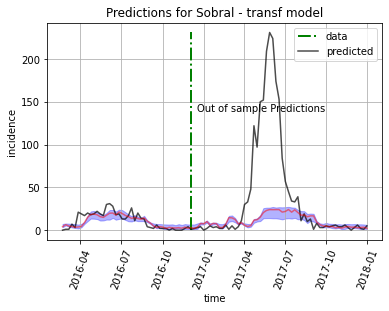

In [26]:
from matplotlib import pyplot as P
indice = list(data_chik.index)
indice = [i.date() for i in indice]

plot_predicted_vs_data(predicted_chik_3,np.concatenate((Y_train_chik, Y_pred), axis=0), indice, 'Sobral - transf model', 4, factor_chik, split_point=len(Y_train_chik), uncertainty= True)


##### Training a new model with only the chik data

In [27]:
%%time
model_chik = build_model(12,X_train_chik.shape[2], 4, 4)

train('chik', model_chik, X_train_chik, Y_train_chik, batch_size=1, epochs=100, geocode= city, overwrite=True)

Compilation Time :  0.003058910369873047
('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 4, 30)]           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 4, 12)             2064      
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 12)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 4, 12)             1200      
_________________________________________________________________
dropout_2 (Dropout)          (None, 4, 12)             0         
_________________________________________________________________
ls

2022-02-13 11:40:19.696057: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2022-02-13 11:40:19.696071: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2022-02-13 11:40:19.696121: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2022-02-13 11:40:22.368397: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2022-02-13 11:40:22.368417: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2022-02-13 11:40:22.500489: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2022-02-13 11:40:22.515683: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2022-02-13 11:40:22.527938: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: ./tensorboard/train/plugins/profile/2022_02_13_11_40_22
2022-02-13 11:40:22.534672: I tensorflow/core/

CPU times: user 11 s, sys: 820 ms, total: 11.8 s
Wall time: 9.7 s


In [28]:
%%time
model_chik =  keras.models.load_model(f'trained_{city}_model_chik.h5')

predicted_in = evaluate(model_chik, X_train_chik, Y_train_chik)
predicted_out = evaluate(model_chik, X_pred, Y_pred)

predicted = np.concatenate((predicted_in, predicted_out), axis=0)

CPU times: user 18.5 s, sys: 523 ms, total: 19 s
Wall time: 16.8 s


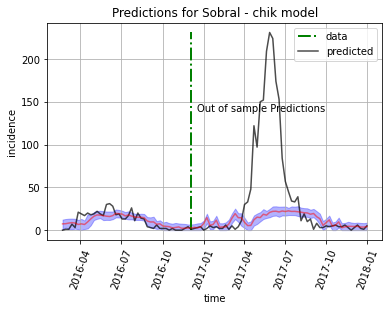

In [29]:
from matplotlib import pyplot as P
indice = list(data_chik.index)
indice = [i.date() for i in indice]

plot_predicted_vs_data(predicted,np.concatenate((Y_train_chik, Y_pred), axis=0), indice, 'Sobral - chik model', 4, factor_chik, split_point=len(Y_train_chik), uncertainty= True)
